In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import re

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import japanize_matplotlib

import random
from tqdm import tqdm


torch.set_default_tensor_type("torch.cuda.FloatTensor")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
df = pd.read_csv('suumo.csv')
df.shape

(5714, 13)

In [3]:
df.head()

,name,address,near_station,built_year,built_floors,floor,rent_fee,manegement_fee,deposit,gratuity,layout,exclusive_area,detail_link
0,京急本線 金沢文庫駅 2階建 築22年,神奈川県横浜市金沢区釜利谷東７,京急本線/金沢文庫駅 歩15分,築22年,2階建,2階,5.3万円,-,5.3万円,-,1K,20.46m2,/chintai/jnc_000065491690/?bc=100234730069
1,ガーデンヒル,神奈川県横浜市南区大岡５,京急本線/上大岡駅 歩8分,築23年,2階建,2階,5.3万円,-,5.3万円,-,1K,20.46m2,/chintai/jnc_000065481271/?bc=100022528817
2,エステートYOKOHAMA,神奈川県横浜市神奈川区松見町２,東急東横線/妙蓮寺駅 歩6分,築30年,2階建,2階,5万円,3000円,5万円,5万円,1K,20.46m2,/chintai/jnc_000065363280/?bc=100233370566
3,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,築29年,4階建,2階,5.3万円,-,5.3万円,5.3万円,ワンルーム,20.14m2,/chintai/jnc_000060810312/?bc=100203962679
4,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,築29年,4階建,2階,5.5万円,-,5.5万円,5.5万円,ワンルーム,20.34m2,/chintai/jnc_000060810311/?bc=100219679401


# データを眺める

In [4]:
df['near_station'].unique()

array(['京急本線/金沢文庫駅 歩15分', '京急本線/上大岡駅 歩8分', '東急東横線/妙蓮寺駅 歩6分', ...,
       'ＪＲ根岸線/石川町駅 バス11分 (バス停)小港 歩1分', 'グリーンライン/センター北駅 歩12分',
       'グリーンライン/センター北駅 歩1分'], dtype=object)

# 整形

In [5]:
df_rent = df.copy()

In [7]:
# near_station
# 最寄り
df_rent['nearest_station_line'] = df_rent['near_station'].apply(
    lambda x: x.split('駅')[0].split('/')[0]
    )
df_rent['nearest_station'] = df_rent['near_station'].apply(
    lambda x: x.split('駅')[0].split('/')[1]+'駅')


'''駅の目的地までの遠さ'''
def method_near_station(x):
    if re.search('バス', x):
        return 'バス'
    elif re.search('歩', x):
        return '歩'

def minutes_near_station(x):
    if re.search('バス', x):
        # バス1分=徒歩5分とする
        bus_minute = 5*int(x.split(' バス')[1].split('分')[0])
        walk_minute = int(x.split('歩')[1].split('分')[0])
        return bus_minute + walk_minute
    elif re.search('歩', x):
        walk_minute = int(x.split('歩')[1].split('分')[0])
        return walk_minute

df_rent['near_station_method'] = df_rent['near_station'].apply(method_near_station)
df_rent['near_station_minute'] = df_rent['near_station'].apply(minutes_near_station)


#i = 1
#df_rent.iloc[i*40+0:i*40+40, 2]

#df_rent['near_station'].apply()

In [8]:
# built_yearは築と年を消去 nanは場合は999をとりあえず入れた->0だった
df_rent['built_year'] = df_rent['built_year'].apply(
    lambda x: int(x.split('築')[1].split('年')[0]) 
                 if x.split('築')[1].split('年')[0]!='' 
                 else 0
    )

In [9]:
# built_floorは複雑そう
def built_floors_underground(x):
    if re.search('地下', x):
        return int(x.split('地下')[1].split('地上')[0])
    else:
        return 0

def built_floors_ground(x):
    if re.search('地上', x):
        return int(x.split('地上')[1].split('階建')[0])
    elif not re.search('地下', x):
        if x == '平屋':
            return 1
        else:
            return int(x.split('階建')[0])
    else:
        return 0



In [10]:
df_rent['built_floors_underground'] = df_rent['built_floors'].apply(built_floors_underground)
df_rent['built_floors_ground'] = df_rent['built_floors'].apply(built_floors_ground)

In [11]:
# floor
for i in range(df_rent.shape[0]):
    x = df_rent.loc[i, 'floor']
    if x=='-':
        df_rent.loc[i, 'floor'] = max(df_rent.loc[i, 'built_floors_underground'], df_rent.loc[i, 'built_floors_ground'])
    elif re.search('-', x):
        y = x.split('-')
        df_rent.loc[i, 'floor'] = (int(y[0])+int(y[-1].split('階')[0]))/2
    else:
        df_rent.loc[i, 'floor'] = int(x.split('階')[0])

In [12]:
# rent_fee
def calc_rent_fee(x):
    if x=='-':
        return 0
    x_splited = x.split('万')[0]
    y = float(x_splited)*10000
    return  y

df_rent['rent_fee'] = df_rent['rent_fee'].apply(calc_rent_fee)

In [13]:
# manegement_fee
df_rent['manegement_fee'] = df_rent['manegement_fee'].apply(
    lambda x: float(x.split('円')[0])
              if x.split('円')[0]!='-'
              else 0
    )

In [14]:
# deposit
df_rent['deposit'] = df_rent['deposit'].apply(calc_rent_fee)

In [15]:
# gratuity
df_rent['gratuity'] = df_rent['gratuity'].apply(calc_rent_fee)

In [16]:
# exclusive_area
def calc_exclusive_area(x):
    if x=='-':
        return 0
    x_splited = x.split('m2')[0]
    y = float(x_splited)
    return  y

df_rent['exclusive_area'] = df_rent['exclusive_area'].apply(calc_exclusive_area)

In [17]:
df_rent.columns

Index(['name', 'address', 'near_station', 'built_year', 'built_floors',
       'floor', 'rent_fee', 'manegement_fee', 'deposit', 'gratuity', 'layout',
       'exclusive_area', 'detail_link', 'nearest_station_line',
       'nearest_station', 'near_station_method', 'near_station_minute',
       'built_floors_underground', 'built_floors_ground'],
      dtype='object')

In [18]:
# 150000以上の物件は抜く
df_rent = df_rent[df_rent['rent_fee']+df_rent['manegement_fee']<150000]

In [49]:
df_rent.head()

,name,address,near_station,built_year,built_floors,floor,rent_fee,manegement_fee,deposit,gratuity,layout,exclusive_area,detail_link,nearest_station_line,nearest_station,near_station_method,near_station_minute,built_floors_underground,built_floors_ground
0,京急本線 金沢文庫駅 2階建 築22年,神奈川県横浜市金沢区釜利谷東７,京急本線/金沢文庫駅 歩15分,22,2階建,2,53000.0,0.0,53000.0,0.0,1K,20.46,/chintai/jnc_000065491690/?bc=100234730069,京急本線,金沢文庫駅,歩,15,0,2
1,ガーデンヒル,神奈川県横浜市南区大岡５,京急本線/上大岡駅 歩8分,23,2階建,2,53000.0,0.0,53000.0,0.0,1K,20.46,/chintai/jnc_000065481271/?bc=100022528817,京急本線,上大岡駅,歩,8,0,2
2,エステートYOKOHAMA,神奈川県横浜市神奈川区松見町２,東急東横線/妙蓮寺駅 歩6分,30,2階建,2,50000.0,3000.0,50000.0,50000.0,1K,20.46,/chintai/jnc_000065363280/?bc=100233370566,東急東横線,妙蓮寺駅,歩,6,0,2
3,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,29,4階建,2,53000.0,0.0,53000.0,53000.0,ワンルーム,20.14,/chintai/jnc_000060810312/?bc=100203962679,東急田園都市線,藤が丘駅,歩,5,0,4
4,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,29,4階建,2,55000.0,0.0,55000.0,55000.0,ワンルーム,20.34,/chintai/jnc_000060810311/?bc=100219679401,東急田園都市線,藤が丘駅,歩,5,0,4


# 正規化

layout はexclusive areaと情報が重複するので除外した
バスか歩きかもバス係数をかけることで削除する

In [19]:
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

In [20]:
# 使用するカラムを絞る
df_rent_ltd =df_rent[['near_station_method', 'near_station_minute','built_year','built_floors_underground','built_floors_ground' ,'floor', 'exclusive_area']]

# 賃料と管理費をまとめて考える ちなみに正規化はmax 100万なので100万倍すると元の値が出るっぽい
df_rent_fee = df_rent[['rent_fee','manegement_fee']].copy()
df_rent_fee['fee'] = df_rent['rent_fee']  + df_rent['manegement_fee'] 
min_fee = df_rent_fee['fee'].min()
max_fee = df_rent_fee['fee'].max()
print(max_fee, min_fee)
df_rent_fee = minmax_norm(df_rent_fee[['fee']])

display(df_rent_ltd)
display(df_rent_fee.head())

148500.0 25000.0


,near_station_method,near_station_minute,built_year,built_floors_underground,built_floors_ground,floor,exclusive_area
0,歩,15,22,0,2,2,20.46
1,歩,8,23,0,2,2,20.46
2,歩,6,30,0,2,2,20.46
3,歩,5,29,0,4,2,20.14
4,歩,5,29,0,4,2,20.34
...,...,...,...,...,...,...,...
5598,歩,5,41,0,2,1.5,70.93
5599,歩,5,41,0,2,1.5,70.93
5600,歩,5,29,0,2,1,70.84
5601,歩,5,28,0,2,2,70.00


,fee
0,0.226721
1,0.226721
2,0.226721
3,0.226721
4,0.242915


In [21]:
# one hotにして考える
df_rent_onehot = minmax_norm(
    pd.get_dummies(df_rent_ltd, columns=['near_station_method']))

In [22]:
df_rent_onehot.head()

,near_station_minute,built_year,built_floors_underground,built_floors_ground,floor,exclusive_area,near_station_method_バス,near_station_method_歩
0,0.110236,0.222222,0.0,0.045455,0.076923,0.145987,0.0,1.0
1,0.055118,0.232323,0.0,0.045455,0.076923,0.145987,0.0,1.0
2,0.03937,0.30303,0.0,0.045455,0.076923,0.145987,0.0,1.0
3,0.031496,0.292929,0.0,0.136364,0.076923,0.143149,0.0,1.0
4,0.031496,0.292929,0.0,0.136364,0.076923,0.144922,0.0,1.0


In [23]:
df_rent_onehot.columns, len(df_rent_onehot.columns)

(Index(['near_station_minute', 'built_year', 'built_floors_underground',
        'built_floors_ground', 'floor', 'exclusive_area',
        'near_station_method_バス', 'near_station_method_歩'],
       dtype='object'),
 8)

# データセット作成

In [24]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

fix_seed(50)

In [25]:
# 全行数
row_num = df_rent_onehot.shape[0]

index_shuffled = random.sample(df_rent_fee.index.tolist(), len(df_rent_fee))

#df_rent_onehot_sample = df_rent_onehot.sample(frac=1)
#df_rent_fee_sample = df_rent_fee.sample(frac=1)
df_rent_onehot_sample = df_rent_onehot.loc[index_shuffled, :].copy()
df_rent_fee_sample = df_rent_fee.loc[index_shuffled, :].copy()

x_train = df_rent_onehot_sample.iloc[0:int(row_num*0.7), :]
x_test = df_rent_onehot_sample.iloc[int(row_num*0.7):, :]
t_train = df_rent_fee_sample.iloc[0:int(row_num*0.7), :]
t_test = df_rent_fee_sample.iloc[int(row_num*0.7):, :]

In [26]:
x_train.head()

,near_station_minute,built_year,built_floors_underground,built_floors_ground,floor,exclusive_area,near_station_method_バス,near_station_method_歩
4128,0.055118,0.474747,0.0,0.045455,0.076923,0.266253,0.0,1.0
2183,0.03937,0.040404,0.0,0.363636,0.076923,0.148736,0.0,1.0
3035,0.07874,0.333333,0.0,0.045455,0.0,0.10643,0.0,1.0
5274,0.070866,0.0,0.0,0.045455,0.0,0.234856,0.0,1.0
1989,0.070866,0.111111,0.0,0.045455,0.0,0.162838,0.0,1.0


# モデル定義

In [27]:
# クラス定義
class CustomDNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.linear1 = nn.Linear(self.input_size, 128)
        self.linear1p5 = nn.Linear(128, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 8)
        self.linear4 = nn.Linear(8, 1)

        self.linear5 = nn.Linear(self.input_size, 1)
        self.linear6 = nn.Linear(self.input_size, 16)
        self.linear7 = nn.Linear(16, 1)

        self.linear8 = nn.Linear(self.input_size, 64)
        self.linear9 = nn.Linear(64, 64)
        self.linear10 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear1p5(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        return x

    def __forward2(self, x):
        x = self.linear6(x)
        x = self.linear7(x)
        return x

    def __forward1(self, x):
        x = self.relu(self.linear8(x))
        x = self.relu(self.linear9(x))
        x = self.relu(self.linear10(x))
        return x

In [28]:
dnn = CustomDNN(len(df_rent_onehot.columns), 1).to(device)

In [29]:
df_rent_onehot.iloc[0, :].values

array([0.11023622047244094, 0.2222222222222222, 0.0, 0.045454545454545456,
       0.07692307692307693, 0.14598669623059868, 0.0, 1.0], dtype=object)

In [30]:
# batchを考えていない
output = dnn(
    torch.unsqueeze(
        torch.from_numpy(
            df_rent_onehot.iloc[0, :].values.astype(np.float32)
            ).clone().to(device),
        axis=0
        )
)
output

tensor([[0.1842]], grad_fn=<ReluBackward0>)

# 学習

In [31]:
model = CustomDNN(len(df_rent_onehot.columns), 1).to(device)

In [32]:
# batch処理用のコードを書かなくてはならない
# validationができていない
def learn(epochs, model):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    loss_list_train = []
    loss_list_test = []
    loss_test = None

    for epoch in tqdm(range(epochs)):
        model.train()
        x = torch.from_numpy(
                x_train.iloc[:, :].values.astype(np.float32)
            ).clone().to(device)
        t = torch.from_numpy(
                t_train.iloc[:, :].values.astype(np.float32)
            ).clone().to(device)

        output = model(
            torch.unsqueeze(x,axis=0))
        loss = loss_fn(output, torch.unsqueeze(t,axis=0))
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_list_train.append(loss)

        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                x = torch.from_numpy(
                        x_test.iloc[:, :].values.astype(np.float32)
                    ).clone().to(device)
                t = torch.from_numpy(
                        t_test.iloc[:, :].values.astype(np.float32)
                    ).clone().to(device)

                output = model(
                    torch.unsqueeze(x,axis=0))
                loss_test = loss_fn(output, torch.unsqueeze(t,axis=0))
                loss_test = loss_test.item()
                loss_list_test.append(loss_test)

        else:
            if loss_test == None:
                loss_list_test.append(loss)
            else:
                loss_list_test.append(loss_test)


    return loss_list_train, loss_list_test

In [33]:
loss_list_train, loss_list_test = learn(10090, model)

100%|██████████| 10090/10090 [00:17<00:00, 584.57it/s]


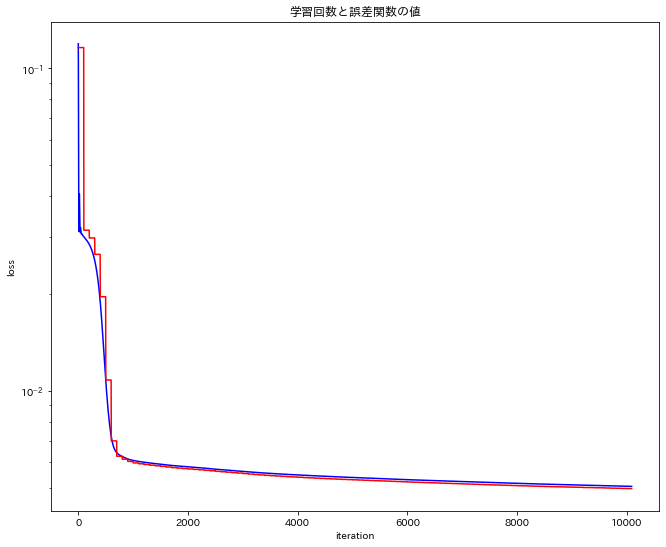

In [34]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_list_train)), loss_list_train, 'blue')
ax1.plot(range(len(loss_list_test)), loss_list_test, 'red')
ax1.set_title('学習回数と誤差関数の値')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss')
ax1.set_yscale('log')
#ax.set_ylim(1e-7, 1)
plt.show()

In [35]:
# 実際の正規化前のデータで予測
i = 1
display(df_rent[df_rent.index==i])

model.eval()
with torch.no_grad():
    output = model(
        torch.unsqueeze(
            torch.from_numpy(
                df_rent_onehot.loc[i, :].values.astype(np.float32)
                ).clone().to(device),
            axis=0
            )
    )
print('predict:', output[0][0]*(148500.0-25000.0))
print('actually:', df_rent_fee.loc[i, :].values[0] * (148500.0-25000.0))

,name,address,near_station,built_year,built_floors,floor,rent_fee,manegement_fee,deposit,gratuity,layout,exclusive_area,detail_link,nearest_station_line,nearest_station,near_station_method,near_station_minute,built_floors_underground,built_floors_ground
1,ガーデンヒル,神奈川県横浜市南区大岡５,京急本線/上大岡駅 歩8分,23,2階建,2,53000.0,0.0,53000.0,0.0,1K,20.46,/chintai/jnc_000065481271/?bc=100022528817,京急本線,上大岡駅,歩,8,0,2


predict: tensor(30167.2910)
actually: 28000.0


In [36]:
df_predicted = df_rent.copy()
df_predicted['predicted_fee'] = 0
for i in range(df_rent_onehot.shape[0]):
    model.eval()
    with torch.no_grad():
        output = model(
            torch.unsqueeze(
                torch.from_numpy(
                    df_rent_onehot.iloc[i, :].values.astype(np.float32)
                    ).clone().to(device),
                axis=0
                )
        )
    df_predicted.iloc[i, -1] = output.to('cpu').detach().numpy().copy()[0][0]*(max_fee + min_fee)+ min_fee

In [37]:
#df_predicted = df_predicted[['name','address','rent_fee','manegement_fee', 'predicted_fee']]
df_predicted['diff'] = df_predicted['predicted_fee'] - df_predicted['rent_fee'] - df_predicted['manegement_fee']
df_predicted.head()

,name,address,near_station,built_year,built_floors,floor,rent_fee,manegement_fee,deposit,gratuity,...,exclusive_area,detail_link,nearest_station_line,nearest_station,near_station_method,near_station_minute,built_floors_underground,built_floors_ground,predicted_fee,diff
0,京急本線 金沢文庫駅 2階建 築22年,神奈川県横浜市金沢区釜利谷東７,京急本線/金沢文庫駅 歩15分,22,2階建,2,53000.0,0.0,53000.0,0.0,...,20.46,/chintai/jnc_000065491690/?bc=100234730069,京急本線,金沢文庫駅,歩,15,0,2,64162.697196,11162.697196
1,ガーデンヒル,神奈川県横浜市南区大岡５,京急本線/上大岡駅 歩8分,23,2階建,2,53000.0,0.0,53000.0,0.0,...,20.46,/chintai/jnc_000065481271/?bc=100022528817,京急本線,上大岡駅,歩,8,0,2,67380.769484,14380.769484
2,エステートYOKOHAMA,神奈川県横浜市神奈川区松見町２,東急東横線/妙蓮寺駅 歩6分,30,2階建,2,50000.0,3000.0,50000.0,50000.0,...,20.46,/chintai/jnc_000065363280/?bc=100233370566,東急東横線,妙蓮寺駅,歩,6,0,2,63362.024188,10362.024188
3,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,29,4階建,2,53000.0,0.0,53000.0,53000.0,...,20.14,/chintai/jnc_000060810312/?bc=100203962679,東急田園都市線,藤が丘駅,歩,5,0,4,68584.330738,15584.330738
4,藤が丘エクセレンス,神奈川県横浜市青葉区藤が丘１,東急田園都市線/藤が丘駅 歩5分,29,4階建,2,55000.0,0.0,55000.0,55000.0,...,20.34,/chintai/jnc_000060810311/?bc=100219679401,東急田園都市線,藤が丘駅,歩,5,0,4,69001.006663,14001.006663


In [38]:
df_predicted[df_predicted['diff']<10000].head() # 相場よりも10000万下回る

,name,address,near_station,built_year,built_floors,floor,rent_fee,manegement_fee,deposit,gratuity,...,exclusive_area,detail_link,nearest_station_line,nearest_station,near_station_method,near_station_minute,built_floors_underground,built_floors_ground,predicted_fee,diff
5,フジコーポ,神奈川県横浜市鶴見区市場東中町,京急本線/鶴見市場駅 歩4分,38,2階建,2,53000.0,0.0,53000.0,53000.0,...,20.30,/chintai/jnc_000017773698/?bc=100235561686,京急本線,鶴見市場駅,歩,4,0,2,61033.031002,8033.031002
6,イーストマリン,神奈川県横浜市鶴見区岸谷４,京急本線/花月総持寺駅 歩6分,31,2階建,1,51000.0,2000.0,0.0,0.0,...,20.26,/chintai/jnc_000064449498/?bc=100229275848,京急本線,花月総持寺駅,歩,6,0,2,61222.981945,8222.981945
12,日吉第一ＱＳハイム,神奈川県横浜市港北区日吉２,東急東横線/日吉駅 歩5分,36,4階建,1,53000.0,0.0,53000.0,53000.0,...,16.00,/chintai/jnc_000059369780/?bc=100220410161,東急東横線,日吉駅,歩,5,0,4,55543.016478,2543.016478
13,日吉第一ＱＳハイム,神奈川県横浜市港北区日吉２,東急東横線/日吉駅 歩5分,36,4階建,2,57000.0,0.0,57000.0,57000.0,...,18.00,/chintai/jnc_000051131215/?bc=100232199101,東急東横線,日吉駅,歩,5,0,4,59997.721836,2997.721836
14,日吉第一ＱＳハイム,神奈川県横浜市港北区日吉２,東急東横線/日吉駅 歩5分,36,4階建,3,57000.0,0.0,57000.0,57000.0,...,16.00,/chintai/jnc_000058484610/?bc=100219656935,東急東横線,日吉駅,歩,5,0,4,56872.153424,-127.846576


In [39]:
df_predicted['diff'].max()

75396.37529850006

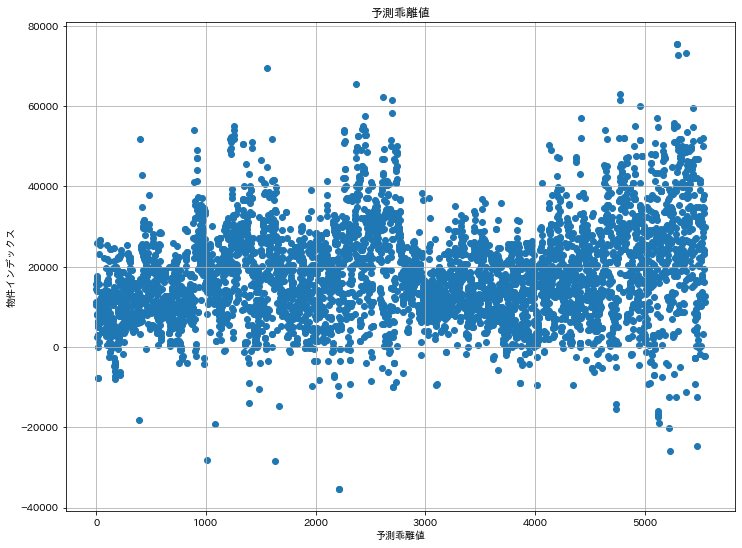

In [40]:
'''
大きい場合は予測が実際を上回っている。低ければ低いほどいい
'''
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.scatter(range(df_predicted.shape[0]), df_predicted['diff'])
ax.set_title('予測乖離値')
ax.set_xlabel('予測乖離値')
ax.set_ylabel('物件インデックス')
ax.grid()
#ax.set_yscale('log')
#ax.set_ylim(1e-7, 1)
plt.show()

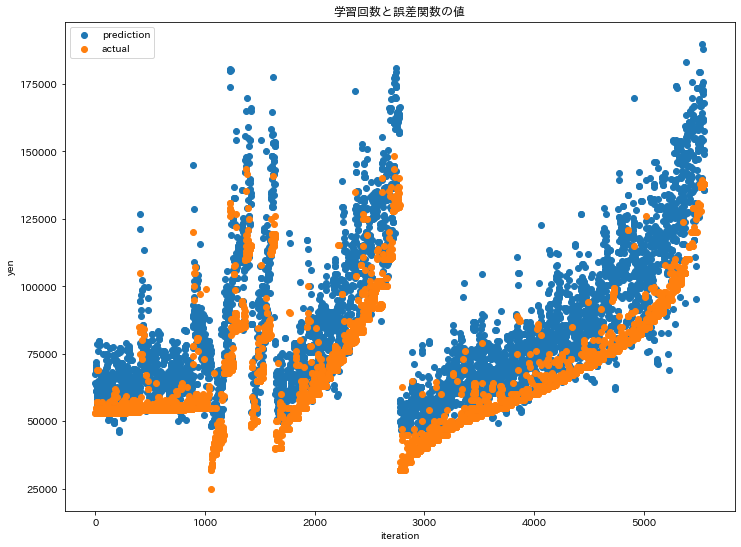

In [41]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.scatter(range(df_predicted.shape[0]), df_predicted['predicted_fee'])
ax.scatter(range(df_predicted.shape[0]), df_predicted['manegement_fee']+df_predicted['rent_fee'])
ax.set_title('学習回数と誤差関数の値')
ax.set_xlabel('iteration')
ax.set_ylabel('yen')
plt.legend(['prediction', 'actual'])
#ax.set_yscale('log')
#ax.set_ylim(1e-7, 1)
plt.show()

# 図示

In [42]:
df_rent_fee

,fee
0,0.226721
1,0.226721
2,0.226721
3,0.226721
4,0.242915
...,...
5598,0.914980
5599,0.914980
5600,0.914980
5601,0.914980


In [43]:
df_rent_fee[df_rent_fee['fee']==1.0]

,fee
2730,1.0


In [44]:
# くそ高物件
df_rent.iloc[2730, :]

name                                              ブルーライン 新横浜駅 3階建 築10年
address                                                  神奈川県横浜市港北区篠原町
near_station                                           ブルーライン/新横浜駅 歩5分
built_year                                                          10
built_floors                                                       3階建
floor                                                                1
rent_fee                                                      122500.0
manegement_fee                                                  6000.0
deposit                                                            0.0
gratuity                                                      122500.0
layout                                                            1LDK
exclusive_area                                                   37.03
detail_link                 /chintai/jnc_000065340016/?bc=100238132796
nearest_station_line                                            ブルーライン
neares

In [45]:
df_rent_fee[df_rent_fee['fee']==df_rent_fee.min().values[0]]

,fee
1055,0.0


In [46]:
# くそ安物件
df_rent.iloc[1055, :]

name                                                            メゾン・リー
address                                                  神奈川県横浜市磯子区岡村６
near_station                                京急本線/上大岡駅 バス9分 (バス停)笹堀 歩3分
built_year                                                          35
built_floors                                                       2階建
floor                                                                1
rent_fee                                                       22000.0
manegement_fee                                                  3000.0
deposit                                                            0.0
gratuity                                                           0.0
layout                                                              1K
exclusive_area                                                   16.56
detail_link                 /chintai/jnc_000066079330/?bc=100237971797
nearest_station_line                                              京急本線
neares

In [47]:
df_rent_fee['fee'].min()

0.0

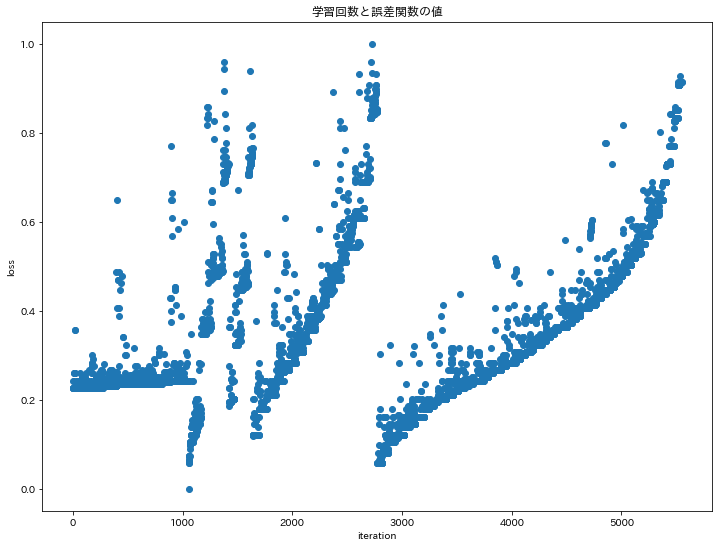

In [48]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.scatter(range(df_rent_fee.shape[0]), df_rent_fee['fee'])
ax.set_title('学習回数と誤差関数の値')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
#ax.set_yscale('log')
#ax.set_ylim(1e-7, 1)
plt.show()